# 🧪 Cointegration Persistence V2: Fixed Beta Analysis
## "Does the Hedge Hold?"

This notebook analyzes the results of `cointegration_persistence_v2.py`.

**Methodology:**
1.  **Training ($t$):** Find cointegrated pairs using a rolling window of size $W$. Optimize $\eta$ and $\alpha$.
2.  **Testing ($t+1$):** Apply the **exact same** $\eta$ and $\alpha$ to the window ending at $t+1$ (shifted forward by 1 day).
3.  **Metric:** Compute the ADF score of the spread $S_{t+1} = Y - (\eta_t X + \alpha_t)$.

If the score remains significant (< -3.34), the hedge is **robust** to short-term changes.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

RESULTS_FILE = Path("/mnt/ssd2/DARWINEX_Mission/results/persistence_v2_fixed_beta.pkl")

with open(RESULTS_FILE, 'rb') as f:
    results = pickle.load(f)

print(f"Loaded results for windows: {list(results.keys())}")


Loaded results for windows: [14, 30, 90]


In [2]:
# Flatten data into a DataFrame
records = []

for w_size, days_data in results.items():
    for day_entry in days_data:
        date = day_entry['date']
        for res in day_entry['data']:
            records.append({
                'Window': w_size,
                'Date': date,
                'Pair': f"{res['y']}-{res['x']}",
                'Score_Train': res['score'],
                'Score_Test_Fixed': res['score_next_day'],
                'Beta': res['beta']
            })

df = pd.DataFrame(records)
print(f"Total opportunities analyzed: {len(df)}")
df.head()


Total opportunities analyzed: 142833


,Window,Date,Pair,Score_Train,Score_Test_Fixed,Beta
0,14,2025-01-17,audchf-audcad,-4.285833,-4.202037,0.212601
1,14,2025-01-17,audnzd-audcad,-3.731699,-3.737398,0.140627
2,14,2025-01-17,cadchf-audcad,-4.595064,-4.307434,-0.471775
3,14,2025-01-17,euraud-audcad,-3.515741,-3.521696,-0.384093
4,14,2025-01-17,eurcad-audcad,-3.639269,-3.630739,1.315579


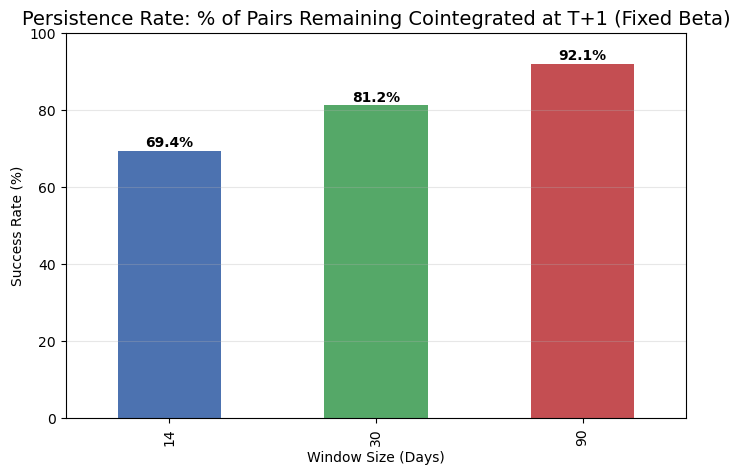

In [3]:
# Define success: Test Score < -3.34 (5% Critical Value)
CRIT_VAL = -3.34

df['Is_Persistent'] = df['Score_Test_Fixed'] < CRIT_VAL

# Group by Window Size
persistence_stats = df.groupby('Window')['Is_Persistent'].mean() * 100

plt.figure(figsize=(8, 5))
persistence_stats.plot(kind='bar', color=['#4c72b0', '#55a868', '#c44e52'])
plt.title('Persistence Rate: % of Pairs Remaining Cointegrated at T+1 (Fixed Beta)', fontsize=14)
plt.ylabel('Success Rate (%)')
plt.xlabel('Window Size (Days)')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 100)

for index, value in enumerate(persistence_stats):
    plt.text(index, value + 1, f"{value:.1f}%", ha='center', fontweight='bold')

plt.show()


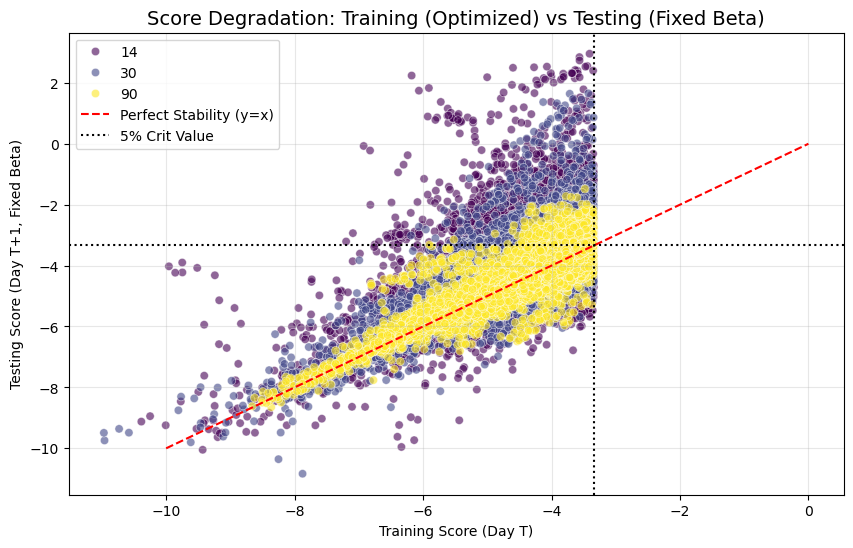

In [4]:
# Compare Train vs Test Scores
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Score_Train', y='Score_Test_Fixed', hue='Window', alpha=0.6, palette='viridis')
plt.plot([-10, 0], [-10, 0], 'r--', label='Perfect Stability (y=x)')
plt.axhline(CRIT_VAL, color='k', linestyle=':', label='5% Crit Value')
plt.axvline(CRIT_VAL, color='k', linestyle=':')

plt.title('Score Degradation: Training (Optimized) vs Testing (Fixed Beta)', fontsize=14)
plt.xlabel('Training Score (Day T)')
plt.ylabel('Testing Score (Day T+1, Fixed Beta)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


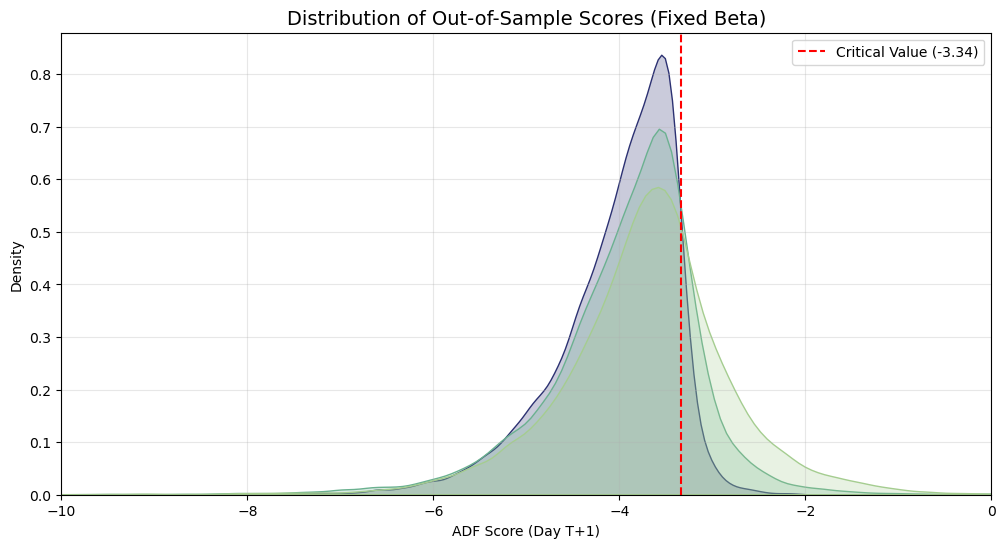

In [5]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='Score_Test_Fixed', hue='Window', fill=True, common_norm=False, palette='crest')
plt.axvline(CRIT_VAL, color='r', linestyle='--', label='Critical Value (-3.34)')
plt.title('Distribution of Out-of-Sample Scores (Fixed Beta)', fontsize=14)
plt.xlabel('ADF Score (Day T+1)')
plt.xlim(-10, 0)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 📊 Conclusions

1.  **Persistence Rate:** Shows the raw probability that a signal generated today will statistically hold tomorrow without re-optimizing the hedge ratio.
2.  **Window Comparison:**
    - **14 Days:** Likely very reactive but unstable. High noise.
    - **30 Days:** Balance?
    - **90 Days:** High stability but potentially lags market turning points.

**Recommendation:** Look for the window size that maximizes the persistence rate while maintaining a sufficient number of trade opportunities.
